In [3]:
import os
import collections
import json
import numpy as np
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip install tensorflow_hub
import tensorflow_hub as hub
!pip install tensorflow_text
!pip install tensorflow_addons
import tensorflow_text as text
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

# Suppressing tf.hub warnings
tf.get_logger().setLevel("ERROR")

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
import collections

annotations_file = "flickr8k/captions.txt"
images_dir = "flickr8k/Images"

with open(annotations_file, "r") as f:
    annotations = f.readlines()

image_path_to_caption = collections.defaultdict(list)
for element in annotations:
    caption = f"{element.lower().rstrip(',')}"
    image_id = element.split(".")[0]
    image_path = os.path.join(images_dir, image_id + ".jpg")
    image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
print(f"Number of images: {len(image_paths)}")

Number of images: 8092


In [10]:
train_size = 3000
valid_size = 1000
captions_per_image = 2
images_per_file = 45
tfrecords_dir = "/content/drive/MyDrive/Colab Notebooks/Tf_records"

image_paths.remove('flickr8k/Images/image,caption\n.jpg')
# image_paths.remove("/content/drive/MyDrive/Colab Notebooks/archive.zip (Unzipped Files)/Images/378453580_21d688748e.jpg")
train_image_paths = image_paths[:train_size]
num_train_files = int(np.ceil(train_size / images_per_file))
train_files_prefix = os.path.join(tfrecords_dir, "train")
valid_image_paths = image_paths[:-valid_size]
num_valid_files = int(np.ceil(valid_size / images_per_file))
valid_files_prefix = os.path.join(tfrecords_dir, "valid")

tf.io.gfile.makedirs(tfrecords_dir)


def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def create_example(image_path, caption):
    feature = {
        "caption": bytes_feature(caption.encode()),
        "raw_image": bytes_feature(tf.io.read_file(image_path).numpy()),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def write_tfrecords(file_name, image_paths):
    caption_list = []
    image_path_list = []
    for image_path in image_paths:
        captions = image_path_to_caption[image_path][:captions_per_image]
        caption_list.extend(captions)
        image_path_list.extend([image_path] * len(captions))

    with tf.io.TFRecordWriter(file_name) as writer:
        for example_idx in range(len(image_path_list)):
            example = create_example(
                image_path_list[example_idx], caption_list[example_idx]
            )
            writer.write(example.SerializeToString())
    return example_idx + 1


def write_data(image_paths, num_files, files_prefix):
    example_counter = 0
    for file_idx in tqdm(range(num_files)):
        file_name = files_prefix + "-%02d.tfrecord" % (file_idx)
        start_idx = images_per_file * file_idx
        end_idx = start_idx + images_per_file
        example_counter += write_tfrecords(file_name, image_paths[start_idx:end_idx])
    return example_counter

train_example_count = write_data(train_image_paths, num_train_files, train_files_prefix)
print(f"{train_example_count} training examples were written to tfrecord files.")

valid_example_count = write_data(valid_image_paths, num_valid_files, valid_files_prefix)
print(f"{valid_example_count} evaluation examples were written to tfrecord files.")

100%|██████████| 67/67 [00:06<00:00, 10.31it/s]


6000 training examples were written to tfrecord files.


100%|██████████| 23/23 [00:00<00:00, 26.18it/s]

2070 evaluation examples were written to tfrecord files.


In [11]:
feature_description = {
    "caption": tf.io.FixedLenFeature([], tf.string),
    "raw_image": tf.io.FixedLenFeature([], tf.string),
}


def read_example(example):
    features = tf.io.parse_single_example(example, feature_description)
    raw_image = features.pop("raw_image")
    features["image"] = tf.image.resize(
        tf.image.decode_jpeg(raw_image, channels=3), size=(299, 299)
    )
    return features


def get_dataset(file_pattern, batch_size):

    return (
        tf.data.TFRecordDataset(tf.data.Dataset.list_files(file_pattern))
        .map(
            read_example,
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=False,
        )
        .shuffle(batch_size * 10)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        .batch(batch_size)
    )

In [12]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = layers.Dense(projection_dims)(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Add()([projected_embeddings, x])
        projected_embeddings = layers.LayerNormalization()(x)
    return projected_embeddings

In [13]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained Xception model to be used as the base encoder.
    xception = keras.applications.Xception(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in xception.layers:
        layer.trainable = trainable
    # Receive the images as inputs.
    inputs = layers.Input(shape=(299, 299, 3), name="image_input")
    # Preprocess the input image.
    xception_input = tf.keras.applications.xception.preprocess_input(inputs)
    # Generate the embeddings for the images using the xception model.
    embeddings = xception(xception_input)
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model(inputs, outputs, name="vision_encoder")

In [14]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the BERT preprocessing module.
    preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2",name="text_preprocessing",)
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",True,)
    # Set the trainability of the base encoder.
    bert.trainable = trainable
    # Receive the text as inputs.
    inputs = layers.Input(shape=(), dtype=tf.string, name="text_input")
    # Preprocess the text.
    bert_inputs = preprocess(inputs)
    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(bert_inputs)["pooled_output"]
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

In [15]:
class DualEncoder(keras.Model):
    def __init__(self, text_encoder, image_encoder, temperature=1.0, **kwargs):
        super().__init__(**kwargs)
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.temperature = temperature
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, features, training=False):
        # Place each encoder on a separate GPU (if available).
        # TF will fallback on available devices if there are fewer than 2 GPUs.
        with tf.device("/gpu:0"):
            # Get the embeddings for the captions.
            caption_embeddings = text_encoder(features["caption"], training=training)
        with tf.device("/gpu:1"):
            # Get the embeddings for the images.
            image_embeddings = vision_encoder(features["image"], training=training)
        return caption_embeddings, image_embeddings

    def compute_loss(self, caption_embeddings, image_embeddings):
        # logits[i][j] is the dot_similarity(caption_i, image_j).
        logits = (
            tf.matmul(caption_embeddings, image_embeddings, transpose_b=True)
            / self.temperature
        )
        # images_similarity[i][j] is the dot_similarity(image_i, image_j).
        images_similarity = tf.matmul(
            image_embeddings, image_embeddings, transpose_b=True
        )
        # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
        captions_similarity = tf.matmul(
            caption_embeddings, caption_embeddings, transpose_b=True
        )
        # targets[i][j] = avarage dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
        targets = keras.activations.softmax(
            (captions_similarity + images_similarity) / (2 * self.temperature)
        )
        # Compute the loss for the captions using crossentropy
        captions_loss = keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )
        # Compute the loss for the images using crossentropy
        images_loss = keras.losses.categorical_crossentropy(
            y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        )
        # Return the mean of the loss over the batch.
        return (captions_loss + images_loss) / 2

    def train_step(self, features):
        with tf.GradientTape() as tape:
            # Forward pass
            caption_embeddings, image_embeddings = self(features, training=True)
            loss = self.compute_loss(caption_embeddings, image_embeddings)
        # Backward pass
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Monitor loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, features):
        caption_embeddings, image_embeddings = self(features, training=False)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [20]:
num_epochs = 15  # In practice, train for at least 30 epochs
batch_size = 32

vision_encoder = create_vision_encoder(num_projection_layers=1, projection_dims=32, dropout_rate=0.1)
text_encoder = create_text_encoder(num_projection_layers=1, projection_dims=32, dropout_rate=0.1)
dual_encoder = DualEncoder(text_encoder, vision_encoder, temperature=0.05)
dual_encoder.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001))

In [21]:
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {int(np.ceil(train_example_count / batch_size))}")
train_dataset = get_dataset(os.path.join(tfrecords_dir, "train-*.tfrecord"), batch_size)
valid_dataset = get_dataset(os.path.join(tfrecords_dir, "valid-*.tfrecord"), batch_size)
# Create a learning rate scheduler callback.
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3
)
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
history = dual_encoder.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=[reduce_lr, early_stopping],
)
print("Training completed. Saving vision and text encoders...")
vision_encoder.save("vision_encoder")
text_encoder.save("text_encoder")
print("Models are saved.")

Batch size: 32
Steps per epoch: 188
Epoch 1/15
    188/Unknown - 55s 262ms/step - loss: 11.5960

2023-12-15 20:53:10.259009: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3723571723331092524
2023-12-15 20:53:10.259055: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13532719841379844500
2023-12-15 20:53:10.259063: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2218986579264143704
2023-12-15 20:53:10.259076: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2632200291182904354
2023-12-15 20:53:10.259081: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13084734711136828146
2023-12-15 20:53:10.259110: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8854044631162097867
2023-12-15 20:53:10.259126: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv i

188/188 [==============================] - 73s 358ms/step - loss: 11.5960 - val_loss: 3.3998 - lr: 0.0010
Epoch 2/15
188/188 [==============================] - 66s 352ms/step - loss: 3.2310 - val_loss: 2.8665 - lr: 0.0010
Epoch 3/15
188/188 [==============================] - 67s 354ms/step - loss: 2.6305 - val_loss: 2.3338 - lr: 0.0010
Epoch 4/15
188/188 [==============================] - 67s 354ms/step - loss: 2.2360 - val_loss: 1.9218 - lr: 0.0010
Epoch 5/15
188/188 [==============================] - 67s 355ms/step - loss: 1.8701 - val_loss: 1.6291 - lr: 0.0010
Epoch 6/15
188/188 [==============================] - 67s 356ms/step - loss: 1.6448 - val_loss: 1.3790 - lr: 0.0010
Epoch 7/15
188/188 [==============================] - 67s 354ms/step - loss: 1.4690 - val_loss: 1.4268 - lr: 0.0010
Epoch 8/15
188/188 [==============================] - 67s 354ms/step - loss: 1.3362 - val_loss: 1.1073 - lr: 0.0010
Epoch 9/15
188/188 [==============================] - 67s 355ms/step - loss: 1.196

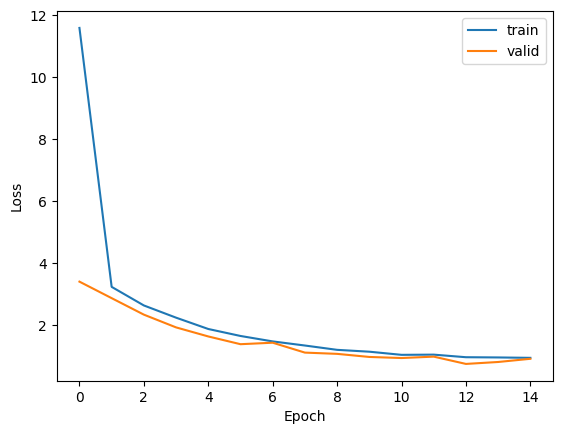

In [22]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()